In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset contents

In [55]:
df = pd.read_json(f"{BASE_DIR}/data/Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [56]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [57]:
df = df[["headline", "is_sarcastic"]]
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      28619 non-null  object
 1   is_sarcastic  28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


## Check for nan

In [59]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [60]:
df["sentence_length"] = df["headline"].apply(lambda x: len(x.split(" ")))
df.head()

,headline,is_sarcastic,sentence_length
0,thirtysomething scientists unveil doomsday clo...,1,8
1,dem rep. totally nails why congress is falling...,0,13
2,eat your veggies: 9 deliciously different recipes,0,7
3,inclement weather prevents liar from getting t...,1,8
4,mother comes pretty close to using word 'strea...,1,9


In [61]:
max_idx = df["sentence_length"].idxmax()
df.iloc[max_idx]["headline"]

'hot wheels ranked number one toy for rolling down ramp, knocking over dominoes that send marble down a funnel, dropping onto teeter-totter that yanks on string, causing pulley system to raise wooden block, propelling series of twine rollers that unwind spring, launching tennis ball across room, inching tire down slope until it hits power switch, activating table fan that blows toy ship with nail attached to it across kiddie pool, popping water balloon that fills cup, weighing down lever that forces basketball down track, nudging broomstick on axis to rotate, allowing golf ball to roll into sideways coffee mug, which tumbles down row of hardcover books until handle catches hook attached to lever that causes wooden mallet to slam down on serving spoon, catapulting small ball into cup attached by ribbon to lazy susan, which spins until it pushes d battery down incline plane, tipping over salt shaker to season omelet'

In [62]:
df["sentence_length"].describe()

count    28619.000000
mean        10.051854
std          3.390939
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max        151.000000
Name: sentence_length, dtype: float64

In [63]:
import plotly.express as px

In [64]:
px.histogram(df, x="sentence_length", height=700, color="is_sarcastic", title="Headlines Length Distribution", marginal="box")

## Target variable distribution
Finding the Classes Balance / Imbalance

In [65]:
plt.style.use("ggplot")

In [66]:
df["is_sarcastic"].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [67]:
# sns.countplot(df, x="is_sarcastic")
px.bar(df.groupby("is_sarcastic").count().reset_index(), x="headline", title="Count of Sarcastic and non-Sarcastic Headlines")

## Data preprocessing

In [68]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [69]:
stop_words = stopwords.words("english") + ["u", "im", "c"]

In [70]:
punc = list(string.punctuation)
lemma = WordNetLemmatizer()

In [19]:
# punc

In [20]:
# def tw_process():
#   df['headline'] = df['headline'].str.lower()
#   # remove the Hashtags from the text
#   df['headline'] = df['headline'].apply(lambda x:re.sub(r'\B#\S+','',x))
#   # remove the links from the text
#   df['headline'] = df['headline'].apply(lambda x:re.sub(r"http\S+", "", x))
#   # remove the Special characters from the text
#   df['headline'] = df['headline'].apply(lambda x:' '.join(re.findall(r'\w+', x)))
#   # substitute the multiple spaces with single spaces
#   df['headline'] = df['headline'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
#   # remove all the single characters in the text
#   df['headline'] = df['headline'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
#   # remove the twitter handlers
#   df['headline'] = df['headline'].apply(lambda x:re.sub('@[^\s]+','',x))

In [72]:
def remove_stopwords(text: str, stop_word_list: list[str]) -> str:
    text = " ".join(word for word in text.split(' ') if word not in stop_words)
    return text

In [71]:
def process(data: str, stop_word_list: list[str]) -> str:
    data = re.sub("\s+\n+", " ", data)
    data = re.sub("[^a-zA-Z0-9]", " ", data)

    data = data.lower()

    data = [
        lemma.lemmatize(word)
        for word in word_tokenize(data)
        if ((word not in set(string.punctuation)) and (word not in stop_words))
        ]
    data = " ".join(data)

    return data

In [73]:
test_idx = 4
print(df["headline"][test_idx])
print(process(df["headline"][test_idx], stop_word_list=stop_words))

mother comes pretty close to using word 'streaming' correctly
mother come pretty close using word streaming correctly


In [74]:
from functools import partial
process = partial(process, stop_word_list=stop_words)
remove_stopwords = partial(remove_stopwords, stop_word_list=stop_words)

In [75]:
df["headline_processed"] = df["headline"].apply(remove_stopwords)
df["headline_processed"] = df["headline"].apply(process)
df.head()

,headline,is_sarcastic,sentence_length,headline_processed
0,thirtysomething scientists unveil doomsday clo...,1,8,thirtysomething scientist unveil doomsday cloc...
1,dem rep. totally nails why congress is falling...,0,13,dem rep totally nail congress falling short ge...
2,eat your veggies: 9 deliciously different recipes,0,7,eat veggie 9 deliciously different recipe
3,inclement weather prevents liar from getting t...,1,8,inclement weather prevents liar getting work
4,mother comes pretty close to using word 'strea...,1,9,mother come pretty close using word streaming ...


## Outliers removal

In [76]:
df = df.drop(df["sentence_length"].idxmax())

In [77]:
df["sentence_length"].describe()

count    28618.000000
mean        10.046929
std          3.287039
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         39.000000
Name: sentence_length, dtype: float64

In [78]:
px.histogram(df, x="sentence_length", height=700, color="is_sarcastic", title="Headlines Length Distribution", marginal="box")

The headlines after the removal of outliers do not exceed the limit of 20-30 words.

# Wordcloud

In [79]:
sarcastic = df[df["is_sarcastic"] == 1]["headline_processed"].tolist()
non_sarcastic = df[df["is_sarcastic"] == 0]["headline_processed"].tolist()

## Sarcastic

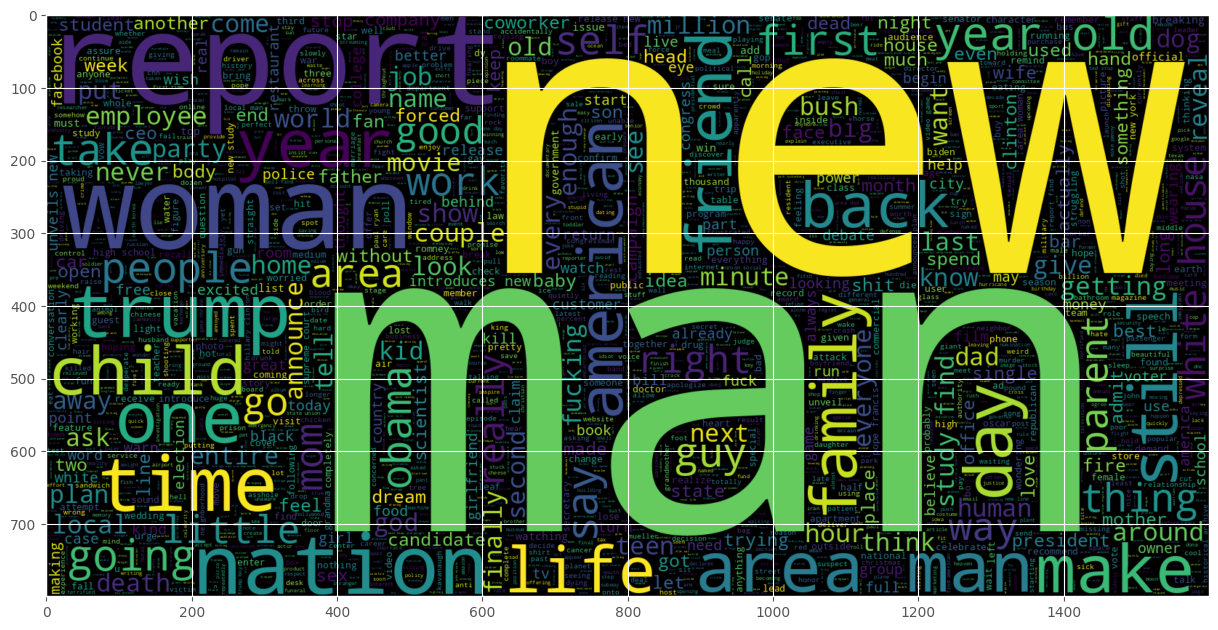

In [80]:
plt.figure(figsize = (15, 15))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(sarcastic))
plt.imshow(wc, interpolation="bilinear")

## Non-sarcastic

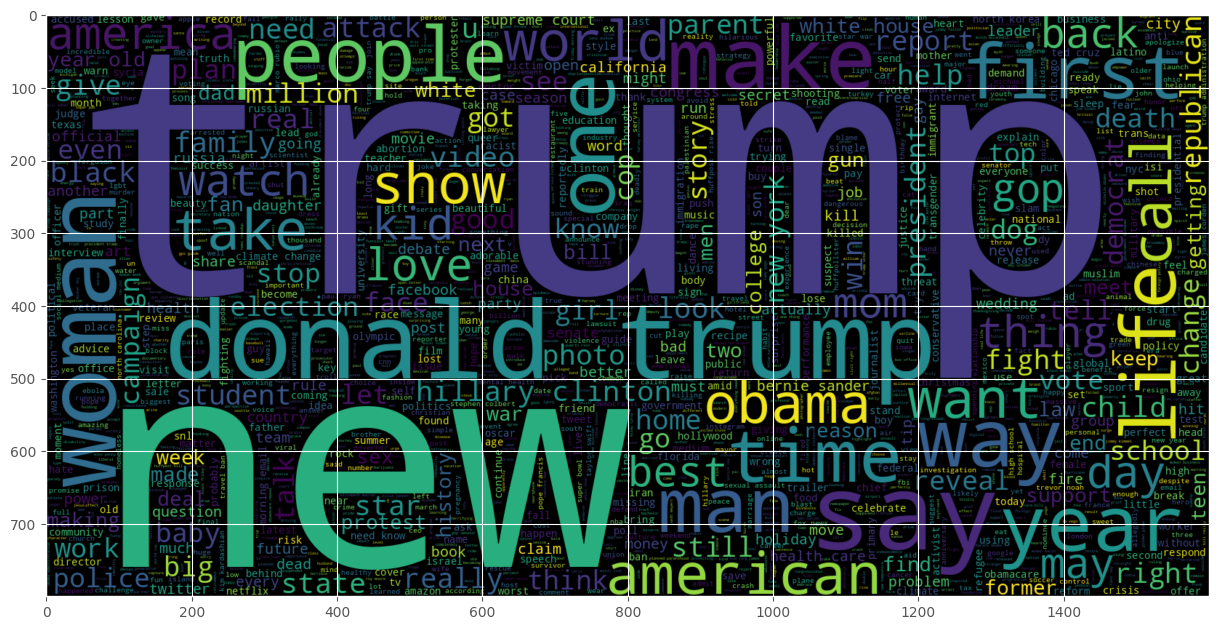

In [81]:
plt.figure(figsize = (15, 15))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(non_sarcastic))
plt.imshow(wc, interpolation="bilinear")

In [82]:
from collections import Counter
import itertools

words = df['headline_processed'].str.split().tolist()
words = list(itertools.chain(*words))

word_freq = Counter(words)
top_100_words = dict(word_freq.most_common(100))

word_freq_df = pd.DataFrame(list(top_100_words.items()), columns=['Word', 'Frequency'])

fig = px.treemap(word_freq_df, path=['Word'], values='Frequency', title='Top 100 Most Frequently Occurring Words')
fig.show()

# Own model LSTM + CNN

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional, Attention
from gensim.models import KeyedVectors

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [84]:
unique_words = set()
for x in df['headline_processed']:
  unique_words.update(x.split())

len(unique_words)
# print(unique_words)

23027

In [85]:
max_sequence_length = df["sentence_length"].max()
num_words = 25000

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df["headline_processed"])
sequences = tokenizer.texts_to_sequences(df["headline_processed"])

X = pad_sequences(sequences, maxlen=max_sequence_length)
y = df["is_sarcastic"].values

In [86]:
y

array([1, 0, 0, ..., 0, 1, 1])

In [87]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [38]:
# Download Google Word2vec embeddings
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [39]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

gzip: GoogleNews-vectors-negative300.bin.gz: No such file or directory


In [88]:
from gensim.models.keyedvectors import KeyedVectors

word2vec = KeyedVectors.load_word2vec_format(f"{BASE_DIR}/data/GoogleNews-vectors-negative300.bin", binary=True)
# word2vec.save_word2vec_format('word2vec_embeddings.txt', binary=False)

In [89]:
embedding_dim = 300

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < num_words:
        # print(word)
        if word in word2vec:
          embedding_vector = word2vec[word]
          embedding_matrix[i] = embedding_vector

In [42]:
def create_model_1(embedding_matrix, max_sequence_length, num_words, embedding_dim):
    model = tf.keras.models.Sequential()

    # Embedding layer
    model.add(tf.keras.layers.Embedding(num_words, embedding_dim,
                                        weights=[embedding_matrix],
                                        input_length=max_sequence_length,
                                        trainable=False))

    # CNN layer
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    # LSTM layer
    model.add(tf.keras.layers.LSTM(128))

    # Dense layer for output
    model.add(tf.keras.layers.Dense(1, activation='softmax'))  # sigmoid
    # adam/adadelta
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model

In [43]:
model_1 = create_model_1(embedding_matrix, max_sequence_length, num_words, embedding_dim)

In [44]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 39, 300)           7500000   
                                                                 
 conv1d (Conv1D)             (None, 35, 128)           192128    
                                                                 
 max_pooling1d (MaxPooling1  (None, 17, 128)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 7823841 (29.85 MB)
Trainable params: 323841 (1.24 MB)
Non-trainable params: 7500000 (28.61 MB)
_____________

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [39]:
rlrp = ReduceLROnPlateau(monitor='val_loss', patience=2,factor=0.01, min_lr=0.00001)

In [47]:
history_1 = model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, callbacks=[early_stopping, rlrp])

Epoch 1/20
358/358 [==============================] - 35s 89ms/step - loss: 0.5062 - accuracy: 0.7502 - val_loss: 0.4895 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 2/20
358/358 [==============================] - 31s 88ms/step - loss: 0.3685 - accuracy: 0.8334 - val_loss: 0.4560 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 3/20
358/358 [==============================] - 31s 88ms/step - loss: 0.2269 - accuracy: 0.9076 - val_loss: 0.4821 - val_accuracy: 0.7980 - lr: 0.0010
Epoch 4/20
358/358 [==============================] - 30s 84ms/step - loss: 0.1106 - accuracy: 0.9569 - val_loss: 0.6286 - val_accuracy: 0.7956 - lr: 0.0010


In [48]:
# Evaluate on test set
loss_1, accuracy_1 = model_1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_1}")

90/90 [==============================] - 1s 16ms/step - loss: 0.5010 - accuracy: 0.7736
Test Accuracy: 0.7735849022865295


In [47]:
def plot_results(model_history):
  plt.figure(figsize=(5, 5))
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.figure(figsize=(5, 5))
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

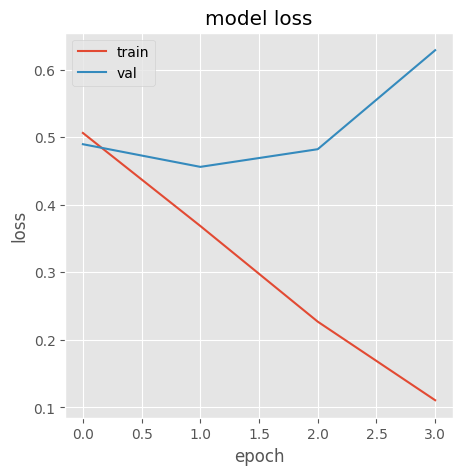

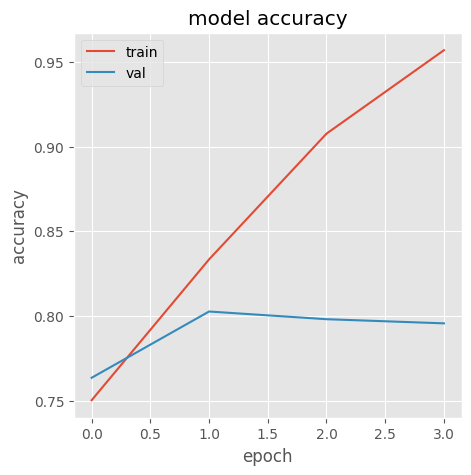

In [50]:
plot_results(history_1)

In [51]:
pred_1 = model_1.predict(X_test)
pred_1 = (pred_1 > 0.5).astype("int32")

pred_1[:5]

90/90 [==============================] - 2s 16ms/step


array([[0],
       [0],
       [1],
       [0],
       [0]], dtype=int32)

[[1380  139]
 [ 509  834]]


<Axes: >

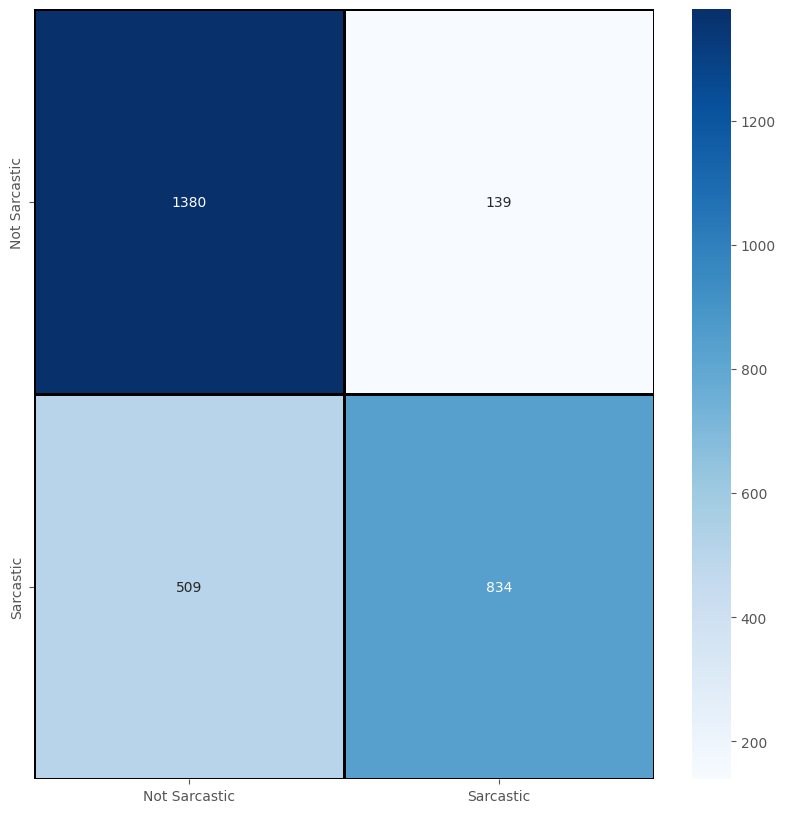

In [52]:
from sklearn.metrics import confusion_matrix

cm_1 = confusion_matrix(y_test, pred_1)
print(cm_1)

cm_1 = pd.DataFrame(cm_1, index=["Not Sarcastic", "Sarcastic"], columns=["Not Sarcastic", "Sarcastic"])
plt.figure(figsize=(10, 10))
sns.heatmap(cm_1, cmap= "Blues", linecolor='black' , linewidth=1, annot=True, fmt='', xticklabels = ['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic','Sarcastic'])

# Model. Recreating from paper

In [53]:
def create_model_2(embedding_matrix, max_sequence_length, num_words, embedding_dim):
    # Input Layer
    input_layer = Input(shape=(max_sequence_length,))

    # Embedding layer
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)(input_layer)

    # CNN Layer
    conv_layer = Conv1D(128, 5, activation='relu')(embedding_layer)
    pool_layer = MaxPooling1D(pool_size=2)(conv_layer)

    # BiLSTM Layer with Attention
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(pool_layer)
    attention_data = tf.keras.layers.Attention()([lstm_layer, lstm_layer])

    # Dense and Output Layers
    flat_layer = Flatten()(attention_data)
    dense_layer = Dense(64, activation='relu')(flat_layer)
    dropout_layer = Dropout(0.5)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    # try adam
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [54]:
model_2 = create_model_2(embedding_matrix, max_sequence_length, num_words, embedding_dim)
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 39)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 39, 300)              7500000   ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 35, 128)              192128    ['embedding_1[0][0]']         
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 17, 128)              0         ['conv1d_1[0][0]']            
 g1D)                                                                                         

In [55]:
history_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, callbacks=[early_stopping, rlrp])

Epoch 1/20
358/358 [==============================] - 87s 230ms/step - loss: 0.6927 - accuracy: 0.4897 - val_loss: 0.6928 - val_accuracy: 0.4888 - lr: 0.0010
Epoch 2/20
358/358 [==============================] - 82s 230ms/step - loss: 0.6924 - accuracy: 0.4997 - val_loss: 0.6926 - val_accuracy: 0.5031 - lr: 0.0010
Epoch 3/20
358/358 [==============================] - 81s 226ms/step - loss: 0.6922 - accuracy: 0.5071 - val_loss: 0.6924 - val_accuracy: 0.5140 - lr: 0.0010
Epoch 4/20
358/358 [==============================] - 82s 228ms/step - loss: 0.6920 - accuracy: 0.5135 - val_loss: 0.6922 - val_accuracy: 0.5241 - lr: 0.0010
Epoch 5/20
358/358 [==============================] - 79s 221ms/step - loss: 0.6918 - accuracy: 0.5199 - val_loss: 0.6920 - val_accuracy: 0.5283 - lr: 0.0010
Epoch 6/20
358/358 [==============================] - 81s 225ms/step - loss: 0.6915 - accuracy: 0.5269 - val_loss: 0.6918 - val_accuracy: 0.5395 - lr: 0.0010
Epoch 7/20
358/358 [==============================] 

In [56]:
# Evaluation
loss_2, accuracy_2 = model_2.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_2}")

90/90 [==============================] - 1s 15ms/step - loss: 0.6883 - accuracy: 0.5671
Test Accuracy: 0.5670859813690186


In [57]:
model_1.save(f"{BASE_DIR}/models/sarcasm_detection_model_1.keras")
model_2.save(f"{BASE_DIR}/models/sarcasm_detection_model_2.keras")

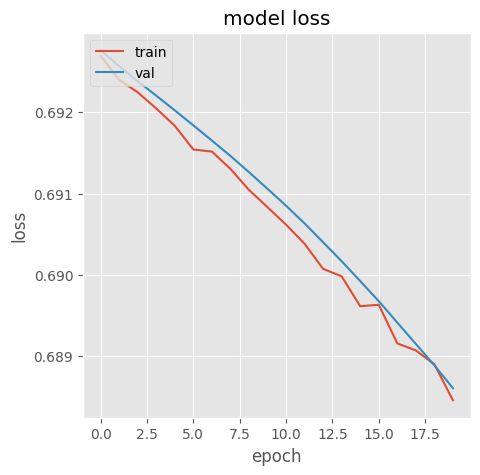

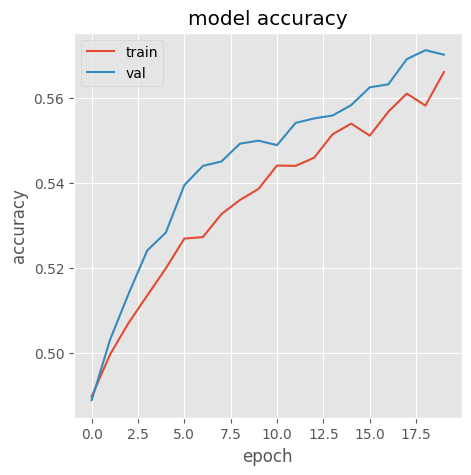

In [58]:
plot_results(history_2)

In [59]:
pred_2 = model_2.predict(X_test)
pred_2 = (pred_2 > 0.5).astype("int32")

pred_2[:5]

90/90 [==============================] - 2s 14ms/step


array([[0],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

[[ 621  898]
 [ 341 1002]]


<Axes: >

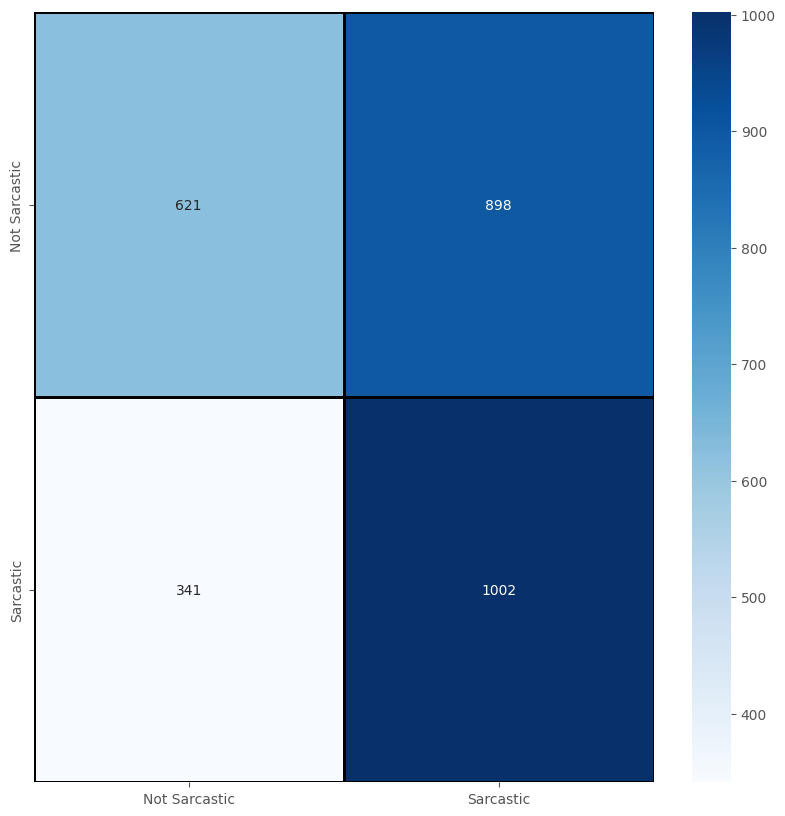

In [60]:
from sklearn.metrics import confusion_matrix

cm_2 = confusion_matrix(y_test, pred_2)
print(cm_2)

cm_2 = pd.DataFrame(cm_2, index=["Not Sarcastic", "Sarcastic"], columns=["Not Sarcastic", "Sarcastic"])
plt.figure(figsize=(10, 10))
sns.heatmap(cm_2, cmap= "Blues", linecolor='black' , linewidth=1, annot=True, fmt='', xticklabels = ['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic','Sarcastic'])

In [43]:
from tensorflow.keras.regularizers import l2
def test_model(embedding_matrix, max_sequence_length, num_words, embedding_dim):
    # Input Layer
    input_layer = Input(shape=(max_sequence_length,))

    # Embedding layer
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)(input_layer)

    # CNN Layer
    conv_layer = Conv1D(128, 5, activation='relu')(embedding_layer)
    pool_layer = MaxPooling1D(pool_size=2)(conv_layer)

    # BiLSTM Layer with Attention
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(pool_layer)
    attention_data = tf.keras.layers.Attention()([lstm_layer, lstm_layer])

    # Dense and Output Layers
    flat_layer = Flatten()(attention_data)
    dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(flat_layer)  # Added L2 regularization
    dropout_layer = Dropout(0.6)(dense_layer)  # Increased dropout rate
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Changed optimizer to 'adam'

    return model


In [52]:
model_test = test_model(embedding_matrix, max_sequence_length, num_words, embedding_dim)
model_test.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 39)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 39, 300)              7500000   ['input_4[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 35, 128)              192128    ['embedding_3[0][0]']         
                                                                                                  
 max_pooling1d_3 (MaxPoolin  (None, 17, 128)              0         ['conv1d_3[0][0]']            
 g1D)                                                                                       

In [66]:
history_test = model_test.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, callbacks=[early_stopping, rlrp])

Epoch 1/20
358/358 [==============================] - 90s 229ms/step - loss: 0.5494 - accuracy: 0.7745 - val_loss: 0.4379 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 2/20
358/358 [==============================] - 80s 225ms/step - loss: 0.2741 - accuracy: 0.9001 - val_loss: 0.4059 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 3/20
358/358 [==============================] - 81s 227ms/step - loss: 0.1253 - accuracy: 0.9613 - val_loss: 0.4956 - val_accuracy: 0.8099 - lr: 0.0010
Epoch 4/20
358/358 [==============================] - 80s 223ms/step - loss: 0.0604 - accuracy: 0.9841 - val_loss: 0.9468 - val_accuracy: 0.8229 - lr: 0.0010


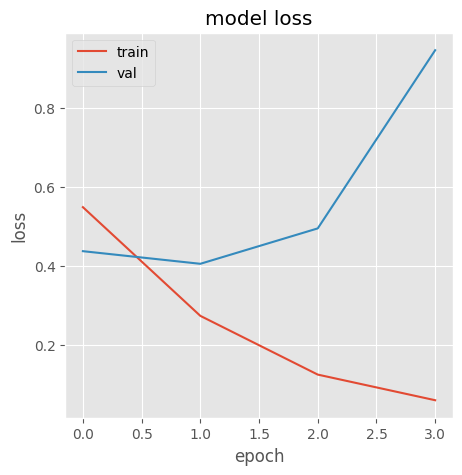

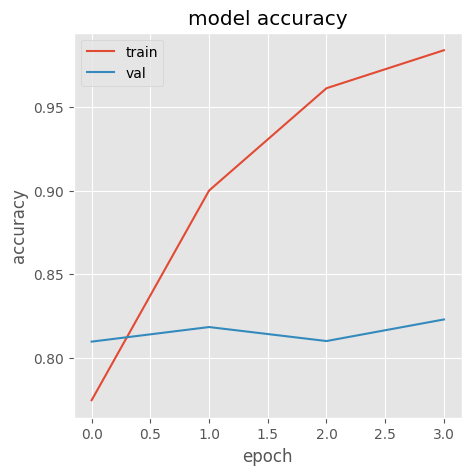

In [68]:
plot_results(history_test)

In [40]:
def test_model_2(embedding_matrix, max_sequence_length, num_words, embedding_dim):
    # Reducing the complexity for long sequences
    input_layer = Input(shape=(max_sequence_length,))

    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)(input_layer)

    # Using a smaller CNN layer
    conv_layer = Conv1D(64, 5, activation='relu')(embedding_layer)
    pool_layer = MaxPooling1D(pool_size=4)(conv_layer)  # Increased pooling size

    # Reducing LSTM units
    lstm_layer = Bidirectional(LSTM(32, return_sequences=True))(pool_layer)
    attention_data = tf.keras.layers.Attention()([lstm_layer, lstm_layer])

    flat_layer = Flatten()(attention_data)
    dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(flat_layer)
    dropout_layer = Dropout(0.6)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [44]:
model_test_2 = test_model_2(embedding_matrix, max_sequence_length, num_words, embedding_dim)
model_test_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 39)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 39, 300)              7500000   ['input_2[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 35, 64)               96064     ['embedding_1[0][0]']         
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 8, 64)                0         ['conv1d_1[0][0]']            
 g1D)                                                                                         

In [45]:
history_test_2 = model_test_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, callbacks=[early_stopping, rlrp])

Epoch 1/20
358/358 [==============================] - 80s 208ms/step - loss: 0.6030 - accuracy: 0.7332 - val_loss: 0.4524 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 2/20
358/358 [==============================] - 71s 199ms/step - loss: 0.3380 - accuracy: 0.8687 - val_loss: 0.4629 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 3/20
358/358 [==============================] - 68s 190ms/step - loss: 0.1860 - accuracy: 0.9358 - val_loss: 0.6959 - val_accuracy: 0.7729 - lr: 0.0010


In [58]:
# Evaluation
loss_test_2, accuracy_test_2 = model_test_2.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_test_2}")

90/90 [==============================] - 2s 22ms/step - loss: 0.4784 - accuracy: 0.7806
Test Accuracy: 0.7805730104446411


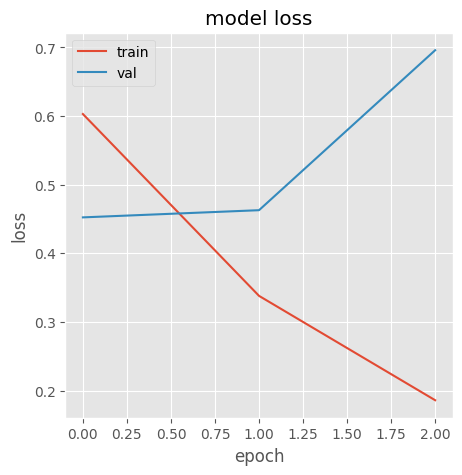

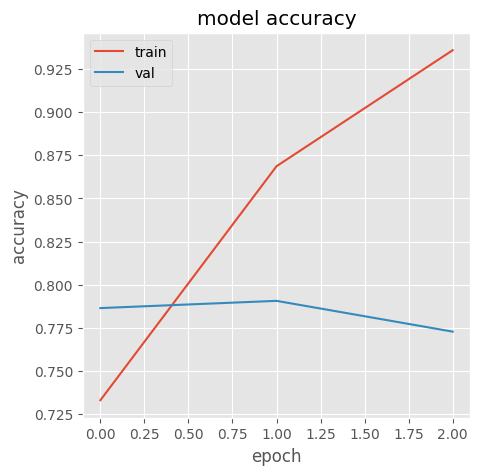

In [48]:
plot_results(history_test_2)

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

model_test_2 = test_model_2(embedding_matrix, max_sequence_length, num_words, embedding_dim)

# Train the model
history_test_2 = model_test_2.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/50
716/716 [==============================] - 135s 180ms/step - loss: 0.5655 - accuracy: 0.7449 - val_loss: 0.4609 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 2/50
716/716 [==============================] - 116s 163ms/step - loss: 0.3300 - accuracy: 0.8718 - val_loss: 0.4934 - val_accuracy: 0.7830 - lr: 0.0010
Epoch 3/50
716/716 [==============================] - 121s 169ms/step - loss: 0.1797 - accuracy: 0.9395 - val_loss: 0.7089 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 4/50
716/716 [==============================] - 116s 162ms/step - loss: 0.1091 - accuracy: 0.9649 - val_loss: 0.7798 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 5/50
716/716 [==============================] - 119s 166ms/step - loss: 0.0670 - accuracy: 0.9783 - val_loss: 1.0828 - val_accuracy: 0.7792 - lr: 2.0000e-04
Epoch 6/50
716/716 [==============================] - 152s 213ms/step - loss: 0.0556 - accuracy: 0.9814 - val_loss: 1.2072 - val_accuracy: 0.7785 - lr: 2.0000e-04


In [59]:
# Evaluation
loss_test_3, accuracy_test_3 = model_test_2.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_test_3}")

90/90 [==============================] - 2s 24ms/step - loss: 0.4784 - accuracy: 0.7806
Test Accuracy: 0.7805730104446411


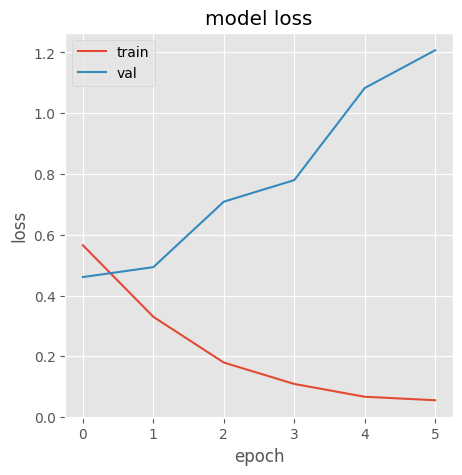

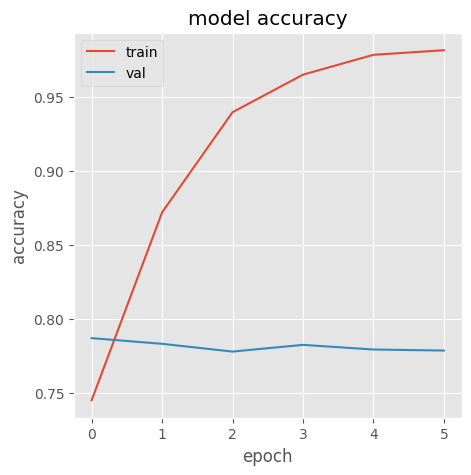

In [51]:
plot_results(history_test_2)

In [53]:
from tensorflow.keras.layers import GlobalMaxPooling1D

def create_model_3(embedding_matrix, max_sequence_length, num_words, embedding_dim):
    input_layer = Input(shape=(max_sequence_length,))

    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)(input_layer)

    # Reduced CNN complexity
    conv_layer = Conv1D(32, 5, activation='relu')(embedding_layer)
    pool_layer = MaxPooling1D(pool_size=4)(conv_layer)

    # Reduced LSTM units
    lstm_layer = Bidirectional(LSTM(16, return_sequences=True))(pool_layer)

    # Global Max Pooling instead of Flatten
    global_max_pooling = GlobalMaxPooling1D()(lstm_layer)

    # Dense and Output Layers
    dense_layer = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(global_max_pooling)
    dropout_layer = Dropout(0.6)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [54]:
model_test_3 = create_model_3(embedding_matrix, max_sequence_length, num_words, embedding_dim)
model_test_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 39, 300)           7500000   
                                                                 
 conv1d_4 (Conv1D)           (None, 35, 32)            48032     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 8, 32)             0         
 g1D)                                                            
                                                                 
 bidirectional_4 (Bidirecti  (None, 8, 32)             6272      
 onal)                                                           
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0   

In [55]:
history_test_3 = model_test_3.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/50
716/716 [==============================] - 118s 156ms/step - loss: 0.6047 - accuracy: 0.7118 - val_loss: 0.4800 - val_accuracy: 0.7834 - lr: 0.0010
Epoch 2/50
716/716 [==============================] - 108s 150ms/step - loss: 0.3904 - accuracy: 0.8365 - val_loss: 0.4856 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 3/50
716/716 [==============================] - 115s 160ms/step - loss: 0.2529 - accuracy: 0.9062 - val_loss: 0.5992 - val_accuracy: 0.7673 - lr: 0.0010
Epoch 4/50
716/716 [==============================] - 104s 145ms/step - loss: 0.1821 - accuracy: 0.9447 - val_loss: 0.6563 - val_accuracy: 0.7851 - lr: 0.0010
Epoch 5/50
716/716 [==============================] - 107s 150ms/step - loss: 0.1353 - accuracy: 0.9609 - val_loss: 0.7962 - val_accuracy: 0.7834 - lr: 2.0000e-04
Epoch 6/50
716/716 [==============================] - 105s 147ms/step - loss: 0.1209 - accuracy: 0.9638 - val_loss: 0.8712 - val_accuracy: 0.7816 - lr: 2.0000e-04


In [60]:
# Evaluation
loss_test_4, accuracy_test_4 = model_test_3.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_test_4}")

90/90 [==============================] - 2s 16ms/step - loss: 0.4968 - accuracy: 0.7690
Test Accuracy: 0.7690426111221313


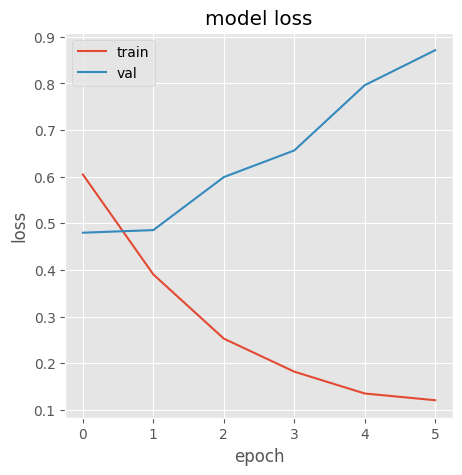

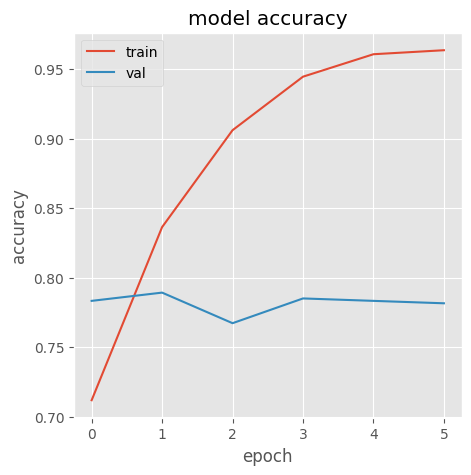

In [56]:
plot_results(history_test_3)

In [61]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Attention

def create_model_5(embedding_matrix, max_sequence_length, num_words, embedding_dim):
    input_layer = Input(shape=(max_sequence_length,))

    # Embedding layer
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)(input_layer)

    # Convolutional Layer
    conv_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding_layer)
    pool_layer = MaxPooling1D(pool_size=2)(conv_layer)

    # Bidirectional LSTM
    lstm_layer = Bidirectional(LSTM(32, return_sequences=True))(pool_layer)

    # Attention
    attention_data = Attention()([lstm_layer, lstm_layer])

    # Global Average Pooling
    global_avg_pooling = GlobalAveragePooling1D()(attention_data)

    # Dense Layer
    dense_layer = Dense(32, activation='relu')(global_avg_pooling)
    dropout_layer = Dropout(0.5)(dense_layer)

    # Output Layer
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [62]:
model_5 = create_model_5(embedding_matrix, max_sequence_length, num_words, embedding_dim)

model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_5 = model_5.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
716/716 [==============================] - 120s 157ms/step - loss: 0.4906 - accuracy: 0.7671 - val_loss: 0.4000 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 2/50
716/716 [==============================] - 112s 157ms/step - loss: 0.2684 - accuracy: 0.8928 - val_loss: 0.4296 - val_accuracy: 0.8208 - lr: 0.0010
Epoch 3/50
716/716 [==============================] - 108s 150ms/step - loss: 0.1159 - accuracy: 0.9586 - val_loss: 0.4967 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 4/50
716/716 [==============================] - 106s 148ms/step - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.8548 - val_accuracy: 0.8159 - lr: 0.0010
Epoch 5/50
716/716 [==============================] - 109s 153ms/step - loss: 0.0133 - accuracy: 0.9963 - val_loss: 1.0241 - val_accuracy: 0.8152 - lr: 2.0000e-04
Epoch 6/50
716/716 [==============================] - 107s 150ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 1.2048 - val_accuracy: 0.8145 - lr: 2.0000e-04


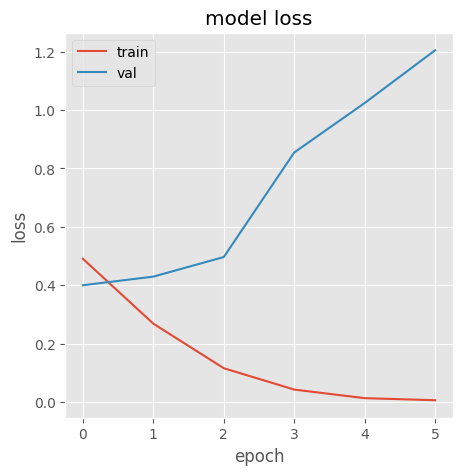

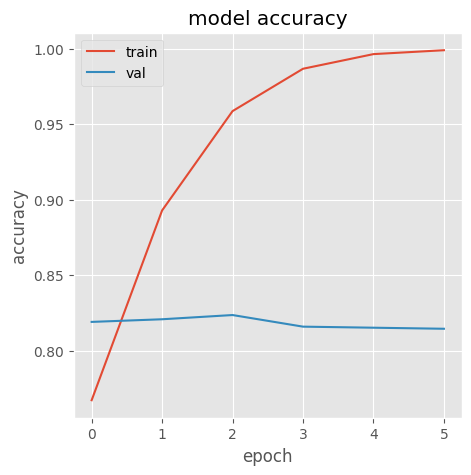

In [63]:
plot_results(history_5)